In [2]:
from __future__ import annotations

import numpy as np
import pandas as pd
import seaborn as sns

from typing import *

sns.set(style="darkgrid")

/Users/personal/Documents/Master of Statistics/2/Modern Data Analytics/Project/G0Z39a/src/nepal/ml/transformers/functions.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, self._name] = log_transformer.transform(X[self._name])


<AxesSubplot:xlabel='fips,date'>

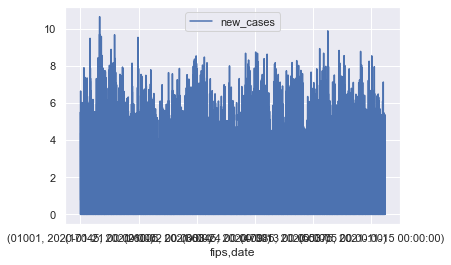

In [3]:
from nepal.datasets import NYTimes, PopulationDensity, GovernmentResponse, Vaccinations
from nepal.ml.features.preprocess import Cases, Population, GovernmentMeasures
from nepal.ml.features.embedding import PersistableEmbedding
from nepal.ml.transformers import TargetTransform, log_transformer

preprocess = TargetTransform()
df: pd.DataFrame = Cases(NYTimes()).preprocessed()
df_y: pd.DataFrame = preprocess.transform(df[["new_cases"]])
df_y.plot()

In [4]:
extra_pop: pd.DataFrame = Population(PopulationDensity()).preprocessed()

extra_measures: pd.DataFrame = GovernmentMeasures(
    response=GovernmentResponse(), vaccinations=Vaccinations()
).preprocessed()

embedding: pd.DataFrame = PersistableEmbedding("counties").load()

In [5]:
import lightgbm as lgb

from sklearn.pipeline import Pipeline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter

from nepal.ml.loss import mape
from nepal.ml.splitter import Splitter
from nepal.ml.validate import cross_validate
from nepal.ml.forecaster import LGBMForecaster
from nepal.ml.transformers import RollingWindowSum, log_transformer

fh = ForecastingHorizon(list(range(1, 15)))
cv = ExpandingWindowSplitter(fh=fh, initial_window=120, step_length=60)
splitter: Splitter = Splitter(cv)

Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

0.3585346689867011


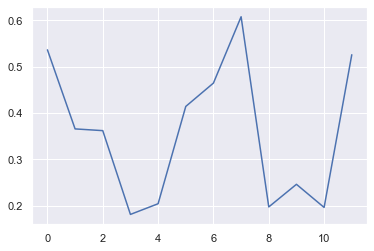

In [6]:
autoregressive_lag: int = 5
measures_lag: int = 12

transformers: Pipeline = Pipeline(
    [
        (
            "with_active_infections",
            RollingWindowSum(
                "new_cases", target="infections", window=10, transformer=log_transformer
            ),
        ),
    ]
)

forecaster = LGBMForecaster(
    lgb.LGBMRegressor(objective=mape.name), lag=autoregressive_lag, transformers=transformers
)

lagged_measures = extra_measures.groupby(level="fips").shift(measures_lag)
Xs = (
    df_y.join(lagged_measures)
    .join(extra_pop)
    .join(embedding)
    .drop(columns=df_y.columns)
    .groupby(level="fips")
    .apply(lambda x: x.fillna(method="ffill").fillna(method="bfill"))
)

scores: Sequence[float] = cross_validate(
    forecaster,
    splitter=splitter,
    y=df_y,
    Xs=Xs,
    loss=mape.function,
)

sns.lineplot(data=scores)
print(np.mean(scores))

In [7]:
import joblib
from nepal.datasets import Dataset

model = forecaster.fit(df_y, Xs=[Xs])

joblib.dump(model, Dataset.ROOT_DIR / "models" / "forecast.joblib")

['/Users/personal/Documents/Master of Statistics/2/Modern Data Analytics/Project/G0Z39a/datasets/models/forecast.joblib']

In [12]:
output: pd.DataFrame = joblib.load(Dataset.ROOT_DIR / "models" / "forecast.joblib").forecast(
    fh=fh, y=df_y, Xs=[Xs]
)

In [15]:
preprocess._pipeline.inverse_transform(output).round()

new_cases
fips  date                 
01001 2022-04-12        8.0
      2022-04-13        8.0
      2022-04-14        7.0
      2022-04-15        7.0
      2022-04-16        7.0
...                     ...
78030 2022-04-21       11.0
      2022-04-22       11.0
      2022-04-23       11.0
      2022-04-24       11.0
      2022-04-25       11.0

[45080 rows x 1 columns]